## Building RNN for Image Identification using PyTorch

In [1]:
!pip3 install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


installing the libs:


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np

### RNN with A Single Neuron




Code:

In [3]:
class SingleRNN(nn.Module):
    def __init__(self, n_inputs, n_neurons):
        super(SingleRNN, self).__init__()
        self.Wx = torch.randn(n_inputs, n_neurons) # 4x1
        self.Wy = torch.randn(n_neurons, n_neurons) # 1x1
        self.b = torch.zeros(1, n_neurons) # 1x4
    def forward(self, X0, X1):
        self.Y0 = torch.tanh(torch.mm(X0, self.Wx) + self.b) 
        self.Y1 = torch.tanh(torch.mm(self.Y0, self.Wy) +   torch.mm(X1, self.Wx) + self.b)
        return self.Y0, self.Y1

In the above code, I have implemented a simple one layer,
one neuron RNN. 
I initialized 2 weights, `Wx` and `Wy`; 

Also my activation function used is 'tanh'



And this is the code to test the model:

In [4]:
N_INPUT = 4
N_NEURONS = 1

X0_batch = torch.tensor( [ [0,1,2,0], [3,4,5,0], [6,7,8,0], [9,0,1,0] ] ,       dtype = torch.float)
X1_batch = torch.tensor( [ [9,8,7,0], [0,0,0,0], [6,5,4,0], [3,2,1,0] ] ,       dtype = torch.float)
model = SingleRNN(N_INPUT, N_NEURONS)
Y0_val, Y1_val = model(X0_batch, X1_batch)

After we have fed the input into the computation graph, we obtain outputs for each timestep (`Y0`, `Y1`):

In [5]:
print(Y0_val)
print(Y1_val)

tensor([[-0.8761],
        [-1.0000],
        [-1.0000],
        [-1.0000]])
tensor([[-1.0000],
        [-0.0997],
        [-1.0000],
        [-0.9999]])


### Increasing Neurons in RNN Layer
now we increase neurons innvolved in the network which in turn wants us to increase the input data too


CODE:

In [6]:
class BasicRNN(nn.Module):
    def __init__(self, n_inputs, n_neurons):
        super(BasicRNN, self).__init__()
        
        self.Wx = torch.randn(n_inputs, n_neurons)
        self.Wy = torch.randn(n_neurons, n_neurons) 
        self.b = torch.zeros(1, n_neurons) 
    
    def forward(self, X0, X1):
        self.Y0 = torch.tanh(torch.mm(X0, self.Wx) + self.b) 
        self.Y1 = torch.tanh(torch.mm(self.Y0, self.Wy) + torch.mm(X1, self.Wx) + self.b) #using mm is better than using matmul
        
        return self.Y0, self.Y1

In [7]:
N_INPUT = 3 #features in input
N_NEURONS = 5 #units in layer

X0_batch = torch.tensor([[0,1,2], [3,4,5], [6,7,8], [9,0,1]],  dtype = torch.float)
X1_batch = torch.tensor([[9,8,7], [0,0,0], [6,5,4], [3,2,1]],  dtype = torch.float)

model = BasicRNN(N_INPUT, N_NEURONS)
Y0_val, Y1_val = model(X0_batch, X1_batch)

Now when we print the outputs produced for each time step, it is of size (4x5), which represents the batch size and number of neurons :)


In [8]:
print(Y0_val)
print(Y1_val)

tensor([[ 0.9715, -0.9766,  0.0052, -0.9870,  0.5240],
        [ 1.0000, -1.0000, -0.9920, -0.9998, -0.5416],
        [ 1.0000, -1.0000, -1.0000, -1.0000, -0.9463],
        [ 1.0000, -1.0000, -1.0000,  1.0000, -0.9977]])
tensor([[ 1.0000, -1.0000, -1.0000, -0.9994, -0.9610],
        [-0.9999,  0.9479,  0.7956,  0.8249,  0.9990],
        [ 1.0000, -1.0000, -0.9994, -0.7016,  0.6278],
        [-0.8624,  0.9527, -0.9756,  0.9990, -0.3854]])


### PyTorch Built-in RNN Cell

In [9]:
rnn = nn.RNNCell(3, 5) # input x   neurons

X_batch = torch.tensor([
                        [[0,1,2], [3,4,5], 
                         [6,7,8], [9,0,1]],
                        
                        [[9,8,7], [0,0,0], 
                         [6,5,4], [3,2,1]]
                       ], 
                       dtype = torch.float) 

hx = torch.randn(4, 5)
output = []

for i in range(2):
    hx = rnn(X_batch[i], hx)
    output.append(hx)

print(output)

[tensor([[ 0.2446,  0.2754,  0.5355,  0.8938,  0.6500],
        [-0.1844,  0.9034,  0.6055,  0.9995,  0.8145],
        [-0.9652,  0.9980,  0.9763,  1.0000,  0.9820],
        [-0.6236, -0.9996, -0.9451,  0.9939, -0.9788]],
       grad_fn=<TanhBackward0>), tensor([[-0.9308,  0.9675,  0.9935,  1.0000,  0.9464],
        [-0.1899, -0.0358,  0.5168,  0.5522,  0.7270],
        [-0.6701,  0.6249,  0.9610,  1.0000,  0.8676],
        [ 0.6517, -0.5705,  0.1597,  0.9703, -0.6797]],
       grad_fn=<TanhBackward0>)]


With the above code, we have basically implemented the same model that was implemented in BasicRNN

Next I'll build the computation graph using the same information we used above.

In [10]:
class CleanBasicRNN(nn.Module):
    def __init__(self, batch_size, n_inputs, n_neurons):
        super(CleanBasicRNN, self).__init__()
        
        self.rnn = nn.RNNCell(n_inputs, n_neurons)
        self.hx = torch.randn(batch_size, n_neurons) # initialize hidden state
        
    def forward(self, X):
        output = []

        for i in range(2):
            self.hx = self.rnn(X[i], self.hx)
            output.append(self.hx)
        
        return output, self.hx

In [11]:
FIXED_BATCH_SIZE = 4
N_INPUT = 3
N_NEURONS = 5

X_batch = torch.tensor([
                        [[0,1,2], [3,4,5], 
                         [6,7,8], [9,0,1]],
                        [[9,8,7], [0,0,0], 
                         [6,5,4], [3,2,1]]
                       ], 
                       dtype = torch.float) 


model = CleanBasicRNN(FIXED_BATCH_SIZE, N_INPUT, N_NEURONS)
output_val, states_val = model(X_batch)
print(output_val) #outputs
print(states_val) #final state

[tensor([[-0.8987, -0.5277, -0.4045,  0.5621, -0.8085],
        [-0.9978, -0.5322, -0.7543,  0.8798, -0.9833],
        [-0.9999, -0.9347, -0.9977,  0.9937, -0.9971],
        [-0.9675, -0.9784, -0.3113, -0.9829, -0.9998]],
       grad_fn=<TanhBackward0>), tensor([[-1.0000, -0.9918, -0.9956,  0.9711, -0.9989],
        [-0.3868,  0.0712,  0.5874,  0.0882,  0.5805],
        [-0.9984, -0.9198, -0.8817,  0.7978, -0.9628],
        [-0.8891, -0.7765, -0.6650,  0.5481, -0.5822]],
       grad_fn=<TanhBackward0>)]
tensor([[-1.0000, -0.9918, -0.9956,  0.9711, -0.9989],
        [-0.3868,  0.0712,  0.5874,  0.0882,  0.5805],
        [-0.9984, -0.9198, -0.8817,  0.7978, -0.9628],
        [-0.8891, -0.7765, -0.6650,  0.5481, -0.5822]],
       grad_fn=<TanhBackward0>)


Here we don't need to explicitly operate on the weights as shown in the previous code

### RNN for Image Classification

IMPORTING MNIST DATABASE AND BUILDING IMAGE IDENTIFIER ON IT


#### Importing the dataset 
let's import the MNIST dataset, split it into test and train portions, do a few transformations, and further explore it. 

In [12]:
import torchvision
import torchvision.transforms as transforms

In [13]:
BATCH_SIZE = 64

# list all transformations
transform = transforms.Compose([transforms.ToTensor()])
# download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
# download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

The code above loads and prepares the dataset to be fed into the computation graph 

#### Exploring the dataset


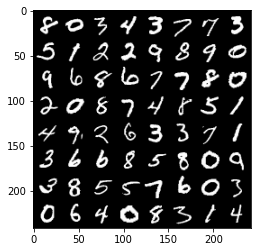

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

#### Model
Let's construct the computation graph. Below are the parameters:

In [15]:
# parameters 
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPOCHS = 20 #no of training iterations

And finally, here is a figure of the RNN-based classification model we are building:


In [16]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(ImageRNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # X's dimension=(steps,batch,input)
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()

        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs)

#### Testing the model

In [17]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
logits = model(images.view(-1, 28,28))
print(logits[0:10])

tensor([[-1.1126e-01,  9.3737e-03, -6.9560e-03, -1.1252e-01,  9.6524e-03,
          7.3706e-02,  6.5035e-02,  1.7344e-02, -4.6952e-03,  1.3059e-02],
        [-1.1774e-01,  1.0815e-02,  9.2558e-03, -1.1275e-01,  1.5831e-02,
          6.9693e-02,  6.6112e-02, -6.8615e-03,  1.0603e-02,  3.5518e-02],
        [-1.1304e-01, -4.5833e-03, -1.5092e-02, -1.8922e-01, -2.6629e-02,
          1.0746e-01,  6.8362e-02, -2.4900e-02, -4.3922e-02, -1.2782e-02],
        [-1.2878e-01, -1.7255e-02, -1.7445e-02, -1.0325e-01, -1.7231e-04,
          6.8286e-02,  6.4328e-02,  1.0524e-02, -8.8058e-03,  2.4174e-02],
        [-1.2605e-01, -2.6459e-02, -2.0283e-02, -1.2304e-01,  1.0385e-02,
          7.1753e-02,  7.1347e-02,  2.5088e-02, -1.5675e-02,  5.3451e-03],
        [-1.2723e-01, -3.9954e-03, -4.0251e-02, -1.0236e-01, -6.8401e-03,
          6.7049e-02,  4.7343e-02,  2.7480e-02,  6.6994e-03,  3.7974e-02],
        [-1.3505e-01, -9.8193e-03, -2.4651e-02, -9.8852e-02,  2.5242e-03,
          7.0225e-02,  6.0150e-0

#### Training

Now let's look at the code for training the image classification model. But first, let's declare a few helper functions needed to train the model:

HELPER FUNCTIONS:

In [18]:
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

""torch.device(...)"" function tells the program that we want to use the GPU 

To compute the loss, the function needs both the log probabilities and targets. 

For activation function I've used loog softmax function

Optimization algorithm updateS weights based on the current loss. 

training our image classification model:

In [ ]:
for epoch in range(N_EPOCHS):  
# loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING 
    for i, data in enumerate(trainloader):

        optimizer.zero_grad()
        # reset hidden states
        model.hidden = model.init_hidden() 
        # inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 
        # forward...backward...optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i)) 
    #printing accuracy

Epoch:  0 | Loss: 0.7315 | Train Accuracy: 76.07
Epoch:  1 | Loss: 0.2769 | Train Accuracy: 92.05
Epoch:  2 | Loss: 0.2000 | Train Accuracy: 94.34
Epoch:  3 | Loss: 0.1647 | Train Accuracy: 95.37
Epoch:  4 | Loss: 0.1540 | Train Accuracy: 95.73
Epoch:  5 | Loss: 0.1402 | Train Accuracy: 96.08
Epoch:  6 | Loss: 0.1314 | Train Accuracy: 96.36
Epoch:  7 | Loss: 0.1187 | Train Accuracy: 96.64
Epoch:  8 | Loss: 0.1228 | Train Accuracy: 96.56
Epoch:  9 | Loss: 0.1101 | Train Accuracy: 96.92
Epoch:  10 | Loss: 0.1034 | Train Accuracy: 97.09
Epoch:  11 | Loss: 0.1011 | Train Accuracy: 97.16
Epoch:  12 | Loss: 0.1011 | Train Accuracy: 97.16
Epoch:  13 | Loss: 0.0980 | Train Accuracy: 97.26
Epoch:  14 | Loss: 0.0869 | Train Accuracy: 97.60
Epoch:  15 | Loss: 0.0965 | Train Accuracy: 97.33


computing the accuracy on MNIST dataset:

In [21]:
test_acc = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 96.19
